In [1]:
from datasets import load_dataset
import pandas as pd
import re
from string import punctuation

In [ ]:
#df = pd.read_csv("Security_Dataset.csv" , index_col=0)
df = pd.read_csv("Full_Dataset.csv" , index_col=0)

df = df[:15000]

In [26]:
len(df)

15000

In [27]:
df["body_text"] = df['body'].astype(str)

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # Remove punctuation
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines
    text = re.sub(r"https?://\S+", "", text)
    return text

df["body_clean"] = df["body_text"].map(preprocess_text)

In [28]:
# Extract abstracts to train on and corresponding titles
abstracts = df["body_clean"]
titles = df["title"]

In [29]:
abstracts[:20] 

0                             look for min file instead
1                                 as an extension of 78
2                                                   nan
3                                                   nan
4     bountysourceplugin want to back this issue pla...
5                                                   nan
6                                                   nan
7     our grunt script is out of control its current...
8     jshint is dropping stylerelated support it see...
9                               after server submission
10    non exhaustive list of improvements remove usa...
11                                    spun off from 428
12    with c11 delete theres no reason to use this c...
13    otherwise the test account gets lots of ccs wh...
14    otherwise the test account gets lots of ccs wh...
15    otherwise the test account gets lots of ccs wh...
16                                                  nan
17                                              

In [30]:
print(titles
      
      [4])

Test ticket from Code Climate


In [31]:
from huggingface_hub import notebook_login

In [32]:
notebook_login()

In [10]:
from torch import cuda

In [11]:
cuda.is_available()

True

In [12]:
model_id = 'meta-llama/Llama-2-13b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'; print(device)


cuda:0


In [13]:
from torch import bfloat16
import transformers

In [14]:
# Quantization to load an LLM with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16,  # Computation type
    #load_in_8bit_fp32_cpu_offload=True # Set if needed for CPU offloading
)

In [15]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

In [16]:
# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [17]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.1)
    Python  3.10.13 (you have 3.10.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [18]:
generator

In [19]:
system_prompt = """
<s>[INST] <<SYS>>
Your task is to provide brief, accurate topic names in the field of Cybersecurity, specifically aligning with the OWASP Top 10 Categories (2021 edition). Each category represents a critical security risk.
<</SYS>>
</s>"""

In [20]:
example_prompt = """
Use these documents and keywords in Cybersecurity to create a concise topic name that aligns with one of the OWASP Top 10 Categories (2021 edition).
Documents:
Analysis of server configurations leading to SSRF vulnerabilities in cloud services.
Case studies on how SSRF attacks are conducted against web servers.
Mitigation strategies for preventing Server-Side Request Forgery in web applications.
Keywords: 'SSRF, cloud services, web servers, mitigation strategies'.
Topic Name:
[/INST]
Preventing Server-Side Request Forgery in Cloud Environments (Aligning with A10:2021 - Server-Side Request Forgery)"""

In [21]:
main_prompt = """
[INST] 
Use these documents and keywords in Cybersecurity to create just one concise topic name that aligns with one of the OWASP Top 10 Categories (2021 edition), described below.
A01:2021 - Broken Access Control: Failures in restricting access, leading to unauthorized data actions.
A02:2021 - Cryptographic Failures: Failures in cryptography causing data exposure or system compromise.
A03:2021 - Injection: Various forms of injection, including SQL, NoSQL, and ORM.
A04:2021 - Insecure Design: Risks related to design flaws and lack of secure design practices.
A05:2021 - Security Misconfiguration: Issues with configurations leading to security vulnerabilities.
A06:2021 - Vulnerable and Outdated Components: Use of vulnerable or outdated software components.
A07:2021 - Identification and Authentication Failures: Failures related to user identification and authentication.
A08:2021 - Software and Data Integrity Failures: Assumptions in software updates and data integrity without verification.
A09:2021 - Security Logging and Monitoring Failures: Inadequate logging and monitoring affecting incident response.
A10:2021 - Server-Side Request Forgery (SSRF): Scenarios where servers are manipulated into executing unintended actions.
[DOCUMENTS]
Keywords: '[KEYWORDS]'.
Return only the Topic name and nothing more.
Topic Name:
[/INST]
"""

In [22]:
prompt = system_prompt + example_prompt + main_prompt

In [31]:
# BERTopic

In [23]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")

In [33]:
len(abstracts)

15000

In [34]:
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [35]:
from umap import UMAP
from hdbscan import HDBSCAN 

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [36]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

/itf-fi-ml/home/pundaris/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [37]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

In [38]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings)


2024-01-18 12:06:37,225 - BERTopic - Reduced dimensionality
2024-01-18 12:06:38,816 - BERTopic - Clustered reduced embeddings
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.09s/it]


In [39]:
# Show top 3 most frequent topics
topic_model.get_topic_info()[1:4]

Topic  Count                                              Name  \
1      0  11764                                   0_the_to_and_in   
2      1   2053                                1_nan_zeus_athena_   
3      2    332  2_imdoneiohttpimdoneio_imdone_efficiently_manage   

                                      Representation  \
1      [the, to, and, in, is, of, we, be, for, that]   
2                  [nan, zeus, athena, , , , , , , ]   
3  [imdoneiohttpimdoneio, imdone, efficiently, ma...   

                                             KeyBERT  \
1  [api, version, update, files, our, from, using...   
2                  [nan, zeus, athena, , , , , , , ]   
3  [imdoneiohttpimdoneio, imdoneio, imdone, comme...   

                                              Llama2  \
1  [Preventing Broken Access Control in Cloud Env...   
2  [Preventing Server-Side Request Forgery in Clo...   
3  [Preventing Technical Debt in Projects through...   

                                                 MMR  \
1      [the, to, and, in, is, of, we, be, for, that]   
2                  [nan, zeus, athena, , , , , , , ]   
3  [imdoneiohttpimdoneio, imdone, efficiently, ma...   

                                 Representative_Docs  
1  [currently the fileactions api action handlers...  
2                                    [nan, nan, nan]  
3  [issue created from code comment with imdoneio...

In [40]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

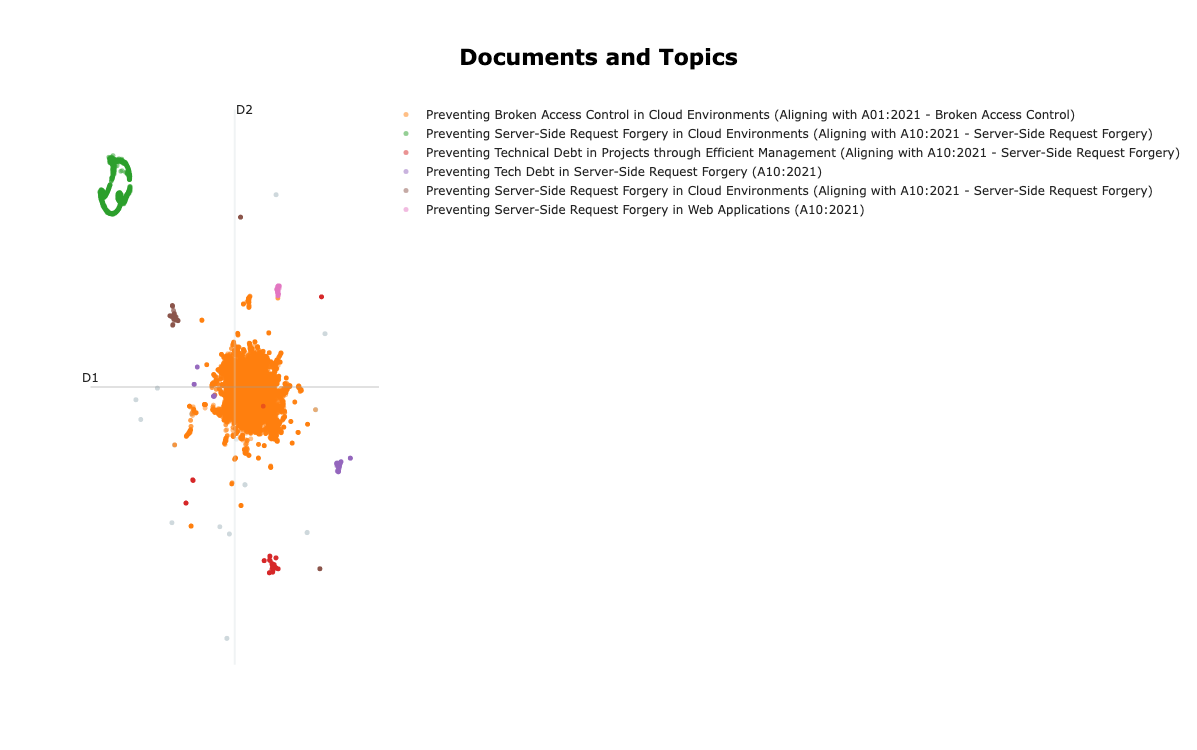

In [41]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, 
hide_annotations=True, hide_document_hover=False, custom_labels=True)